In [16]:
import importlib
import torch
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from PIL import Image

from matplotlib import pyplot as plt
from utils import img, pyramid, stats, hooking

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [2]:
vgg = models.vgg19(pretrained=True)

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU (so freezing beforehand would have no effect).

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg = vgg.to(device)
for param in vgg.features.parameters(): # stop training the net
    param.requires_grad = False

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working.

In [4]:
vgg_layers = list(vgg.children())[0]

for i in range(len(vgg_layers)):
    if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
        vgg_layers[i] = nn.AvgPool2d(2)

Lastly, we'll remove the fully connected layers from our pretained vgg network. We don't need these for texture synthesis, and leaving them in limits us to input images of size 224x224 only.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list in order to interact with it. With vgg19 what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [48]:
useful_layers = list(vgg.children())[0]
vgg = nn.Sequential(useful_layers)
len(list(vgg.children())[0]) # should be 37

37

## Perpairing the example texture

The pre-trained networks from torchvision.models need to be passed inputs in a certain format, so we're going to add a transform to apply those transformations to all the image's we're dealing with. We also define a helper function `image_loader` which takes a relative image path, loads the image into a tensor, applies the relevant transformations and returns it.

`show_image` makes it easier to view images we load using `image_loader`. Pytorch doesn't seem to have any good method for visualizing tensors, so we convert the tensor to a numpy array, transpose it and then plot that using matplotlib.

**Note:** `unsqueeze()` is a pytorch function that adds extra dimensions to tensors. We're using it here because vgg19 only takes mini-batches of images, and we're working with a single image. We use `.unsqueeze()` to add the extra dimension to our image tensor and trick vgg into thinking it's dealing with a small minibatch of images. 

**Note 2:** For classification vgg19 expects input images to be normalized according to imagenet mean values. The commented out line below applies this transform. We're not doing classification though and *should not* add it here. It would cause our sample textures to be optimized to look like the *normalized* version of the example texture (i.e. off color and weird). See `data/samples/stones-normalized` for what happened to me. We can also ignore the usual size constraint of 224x224 since convolutional layers are size-agonstic and we already removed all the fully connected layers.

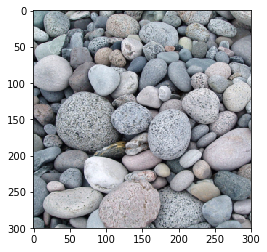

In [49]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(300),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_path = "data/examples/"
img_name = "stones.jpg" # we use this variable later
full_path = img_path + img_name

example_texture = img.image_loader(full_path, transform)
img.show_image(example_texture)

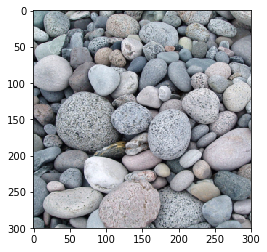

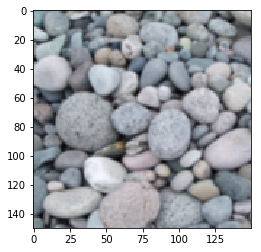

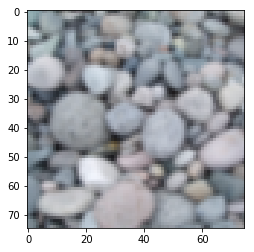

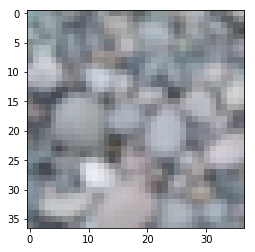

In [50]:
gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)

example_pyr = pyramid.gaussian_pyramid(example_texture, gaussian_kernel, max_levels=3)
for pyr_slice in example_pyr:
    img.show_image(pyr_slice)

The paper reccomends using the 3rd and 8th layers (only counting conv and pooling layers)

In [57]:
importlib.reload(stats)
hooks = hooking.attach_hooks(vgg, [4, 12])
print(len(hooks)) # should be 2

example_feature_pyr = []

for pyr_slice in example_pyr:
    vgg(pyr_slice)
    slice_stats = [stats.gram_matrix(hook.features) for hook in hooks]
    example_feature_pyr.append(slice_stats)

2


## Computing Loss

Next we need a way of generating a loss from the example summary statistics (above), and some sample summary statistics (which we will eventually generate by passing the sample texture through our vgg network in exactly the same way). The paper recommends calculating the **mean squared error** loss between the two sets of gram matrices.

I had a lot of trouble with this. The losses were always tiny (probably because, as above, the gram matrices I calculated from the feature maps tended to hold super small values), and often resulted in outright 0 gradients. The hacky-as-balls solution I came up with was to literally just scale the loss by some factor before returning. Gross I know.

The paper also recommends using LBFGS to perform gradient updates. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html) for this which you should probably look up. The main takeaway is: if you're using `torch.optim.LBFGS()` as your optimizer, you can't just call `optimizer.step()` like normal. Instead, you need to pass in a special `closure()` function that calculates and returns your loss. Because we can't pass any arguments to the `closure()` function directly, we're going to create a class (`GradientStepper`) around this `closure()` function and use attribute variables on that class as parameters to our `closure()`. 

We'll also add our loss function to this class for conveniance.

In [58]:
class GradientStepper():
    gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)
    
    def __init__(self, optimizer, model, sample, example_feature_pyr, hooks, scale):
        self.optimizer = optimizer
        self.sample = sample
        self.example_feature_pyr = example_feature_pyr
        self.model = model
        self.hooks = hooks
        self.scale = scale
        self.losses = []

    def loss_fn(self, sample_feature_pyr):
        loss = 0
        
        for i in range(len(sample_feature_pyr)):
            sample_stats = sample_feature_pyr[i]
            target_stats = self.example_feature_pyr[i]
            
            for j in range(len(sample_stats)):
                loss += torch.mean((sample_stats[j] - target_stats[j]).pow(2)) # mean squared error

        print("scale: {}".format(self.scale))
        return loss * self.scale
    
    def gaussian_pyramid(self):
        return pyramid.gaussian_pyramid(self.sample, self.gaussian_kernel, max_levels=2)
    
    def closure(self):
        self.optimizer.zero_grad() # Please read up on this if you don't know what it does. 
        
        sample_pyr = self.gaussian_pyramid()
        sample_feature_pyr = []
        
        for sample in sample_pyr:
            self.model(sample)
            sample_feature_pyr.append([stats.gram_matrix(hook.features) for hook in self.hooks])

        loss = self.loss_fn(sample_feature_pyr)
        self.losses.append(loss)
        loss.backward()

        print("loss: {}".format(loss))

        return loss


## Create the Sample Texture

Nearly there. Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it against the above loss function until its summary statistics more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them.


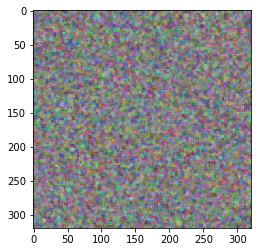

In [59]:
img.show_image(img.random_image(5))

## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture. Once that's done it should look a bit like the example texture (hopefully). To make this clean and reusable, we're going to pack this process into a class called `Synthesizer`, which will take in a bunch of hyperparameters and also save the generated textures as `.jpg`'s for viewing later.

First though, we're going to define some conveniance functions.

### Viewing Images

Rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going. I'm going to give each image an "identifier", which is basically just a string representation of the hyperparameters used to generate it.


In [60]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["hooks", "model", "iterations", "id"]:
            if key == "name":
                id += params[key].replace(".jpg", "") + "-"
            else:
                id += "{}{}-".format(key, params[key])
        
    return id[:-1]

### Synthesizer

The only important method is `synthesize`, the rest of it is just there to save the sample textures to the right directories. Basically this method takes a bunch of hyperparameters, generates a (quasi) random image, and performs gradient updates on it for a given number of iterations using the `GradientStepper` class we defined earlier.

In [61]:
class Synthesizer():
    def __init__(self, params):
        self.saver = img.Saver(params["save_mode"])
        self.example_feature_pyr = params["example_feature_pyr"]
        self.save_at = 1 if params["save_mode"] == "throughout" else 0
    
    def synthesize(self, params):
        if self.save_at == 0:
            self.save_at = params["iterations"]
        
        sample_texture = img.random_image(params["blur"], params["size"])
        optimizer = optim.LBFGS([sample_texture], lr=params["lr"])
        stepper = GradientStepper(optimizer, params["model"], sample_texture, self.example_feature_pyr, params["hooks"], params["scale"])
        
        self.saver.prepair_save_directory(params)

        for i in range (params["iterations"]):
            if sample_texture.grad is not None:
                print(sample_texture.grad[0][0][0][:4])

            optimizer.step(stepper.closure)

            # occationally save an image so see how generation is going
            if (i + 1) == self.save_at:
                self.saver.save_image(sample_texture, self.save_at)
                self.save_at *= 2

                if params["scale_decay"] > 0:
                    stepper.scale -= (stepper.scale / params["scale_decay"])
        
        self.save_at = 0
        return sample_texture, stepper.losses

### Execution

Feel free to fiddle around with hyperparameters here, but I did a fair bit of fiddling myself, and to be honest  the only thing that seemed to make any real difference was the scale, which just needed to remain > 10,000.

xstd-normalized-stones-size150-layers5-blur3-scale_decay0-scale1000000-lr0.01
scale: 1000000
loss: 8.834714889526367
scale: 1000000
loss: 8.834665298461914
scale: 1000000
loss: 8.747817993164062
scale: 1000000
loss: 8.659991264343262
scale: 1000000
loss: 8.577583312988281
scale: 1000000
loss: 8.501791000366211
scale: 1000000
loss: 8.414729118347168
scale: 1000000
loss: 8.328853607177734
scale: 1000000
loss: 8.251665115356445
scale: 1000000
loss: 8.157691955566406
scale: 1000000
loss: 8.06795597076416
scale: 1000000
loss: 7.987668037414551
scale: 1000000
loss: 7.89539909362793
scale: 1000000
loss: 7.804734230041504
scale: 1000000
loss: 7.721465587615967
scale: 1000000
loss: 7.632987022399902
scale: 1000000
loss: 7.551951885223389
scale: 1000000
loss: 7.481168270111084
scale: 1000000
loss: 7.415366172790527
scale: 1000000
loss: 7.341068744659424
tensor([0.0015, 0.0014, 0.0007, 0.0022], device='cuda:0')
scale: 1000000
loss: 7.268951892852783
scale: 1000000
loss: 7.183065414428711
scale: 1

scale: 1000000
loss: 0.4222152829170227
scale: 1000000
loss: 0.41724205017089844
scale: 1000000
loss: 0.4130060374736786
scale: 1000000
loss: 0.4090616703033447
scale: 1000000
loss: 0.40515217185020447
scale: 1000000
loss: 0.40190473198890686
scale: 1000000
loss: 0.3981629014015198
tensor([0.0001, 0.0001, 0.0001, 0.0001], device='cuda:0')
scale: 1000000
loss: 0.3950995206832886
scale: 1000000
loss: 0.3930172622203827
scale: 1000000
loss: 0.3897325098514557
scale: 1000000
loss: 0.3867723345756531
scale: 1000000
loss: 0.3842431604862213
scale: 1000000
loss: 0.38162046670913696
scale: 1000000
loss: 0.37922218441963196
scale: 1000000
loss: 0.37692394852638245
scale: 1000000
loss: 0.37507838010787964
scale: 1000000
loss: 0.3721790313720703
scale: 1000000
loss: 0.3700215518474579
scale: 1000000
loss: 0.3678104281425476
scale: 1000000
loss: 0.36619308590888977
scale: 1000000
loss: 0.36379361152648926
scale: 1000000
loss: 0.3615851402282715
scale: 1000000
loss: 0.3587850332260132
scale: 100000

scale: 1000000
loss: 0.24326613545417786
scale: 1000000
loss: 0.2428661286830902
scale: 1000000
loss: 0.24246111512184143
scale: 1000000
loss: 0.24213244020938873
scale: 1000000
loss: 0.24174010753631592
scale: 1000000
loss: 0.24142028391361237
scale: 1000000
loss: 0.24105040729045868
scale: 1000000
loss: 0.24057956039905548
scale: 1000000
loss: 0.24030353128910065
scale: 1000000
loss: 0.23994769155979156
scale: 1000000
loss: 0.23954232037067413
scale: 1000000
loss: 0.2390470951795578
scale: 1000000
loss: 0.23860400915145874
scale: 1000000
loss: 0.2382415235042572
scale: 1000000
loss: 0.23792967200279236
scale: 1000000
loss: 0.23768563568592072
scale: 1000000
loss: 0.2373473346233368
scale: 1000000
loss: 0.23699115216732025
tensor([ 0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 1000000
loss: 0.23668798804283142
scale: 1000000
loss: 0.23635026812553406
scale: 1000000
loss: 0.23592355847358704
scale: 1000000
loss: 0.23555488884449005
scale: 1000000
loss: 0.23521104454994202

scale: 1000000
loss: 0.16414883732795715
scale: 1000000
loss: 0.1638837605714798
scale: 1000000
loss: 0.1636078953742981
scale: 1000000
loss: 0.16321058571338654
scale: 1000000
loss: 0.16286909580230713
scale: 1000000
loss: 0.1626204550266266
scale: 1000000
loss: 0.16239814460277557
tensor([0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
scale: 1000000
loss: 0.1621415615081787
scale: 1000000
loss: 0.16183938086032867
scale: 1000000
loss: 0.16158290207386017
scale: 1000000
loss: 0.1612786203622818
scale: 1000000
loss: 0.1609002947807312
scale: 1000000
loss: 0.16064563393592834
scale: 1000000
loss: 0.16034239530563354
scale: 1000000
loss: 0.16002406179904938
scale: 1000000
loss: 0.15972429513931274
scale: 1000000
loss: 0.15942588448524475
scale: 1000000
loss: 0.15918703377246857
scale: 1000000
loss: 0.1589323729276657
scale: 1000000
loss: 0.15865091979503632
scale: 1000000
loss: 0.1583799421787262
scale: 1000000
loss: 0.15805114805698395
scale: 1000000
loss: 0.15779712796211243
scale: 

scale: 1000000
loss: 0.12595145404338837
scale: 1000000
loss: 0.12581993639469147
scale: 1000000
loss: 0.12568587064743042
scale: 1000000
loss: 0.12557029724121094
scale: 1000000
loss: 0.12546107172966003
scale: 1000000
loss: 0.12536244094371796
scale: 1000000
loss: 0.1252155750989914
scale: 1000000
loss: 0.12511958181858063
scale: 1000000
loss: 0.12502792477607727
scale: 1000000
loss: 0.12489132583141327
scale: 1000000
loss: 0.12475430965423584
scale: 1000000
loss: 0.12465544044971466
scale: 1000000
loss: 0.12448849529027939
scale: 1000000
loss: 0.12438806891441345
scale: 1000000
loss: 0.1243104636669159
scale: 1000000
loss: 0.12414097040891647
scale: 1000000
loss: 0.12401466071605682
scale: 1000000
loss: 0.12389446794986725
scale: 1000000
loss: 0.1237265095114708
tensor([ 3.6296e-06,  5.5560e-07, -7.0921e-06,  2.3252e-07], device='cuda:0')
scale: 1000000
loss: 0.12361858040094376
scale: 1000000
loss: 0.12354527413845062
scale: 1000000
loss: 0.12338390201330185
scale: 1000000
loss: 0.

scale: 1000000
loss: 0.10663917660713196
scale: 1000000
loss: 0.10655268281698227
scale: 1000000
loss: 0.10649222880601883
scale: 1000000
loss: 0.10642179101705551
scale: 1000000
loss: 0.10634227097034454
scale: 1000000
loss: 0.10627050697803497
scale: 1000000
loss: 0.10621364414691925
scale: 1000000
loss: 0.10615701973438263
scale: 1000000
loss: 0.1060691550374031
scale: 1000000
loss: 0.1059739738702774
scale: 1000000
loss: 0.10589444637298584
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 1000000
loss: 0.10583391785621643
scale: 1000000
loss: 0.105727918446064
scale: 1000000
loss: 0.10563617944717407
scale: 1000000
loss: 0.10554861277341843
scale: 1000000
loss: 0.10543962568044662
scale: 1000000
loss: 0.10538433492183685
scale: 1000000
loss: 0.1052381843328476
scale: 1000000
loss: 0.10516319423913956
scale: 1000000
loss: 0.10506666451692581
scale: 1000000
loss: 0.10499412566423416
scale: 1000000
loss: 0.10490775853395462
scale: 1000000
loss: 0.1048390343785286
s

scale: 1000000
loss: 0.09578847885131836
scale: 1000000
loss: 0.09573855996131897
scale: 1000000
loss: 0.09568243473768234
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 1000000
loss: 0.09563907235860825
scale: 1000000
loss: 0.0956098884344101
scale: 1000000
loss: 0.09557585418224335
scale: 1000000
loss: 0.09553243964910507
scale: 1000000
loss: 0.09549745917320251
scale: 1000000
loss: 0.09545330703258514
scale: 1000000
loss: 0.09542062878608704
scale: 1000000
loss: 0.09537027031183243
scale: 1000000
loss: 0.09532688558101654
scale: 1000000
loss: 0.09527260810136795
scale: 1000000
loss: 0.0952455997467041
scale: 1000000
loss: 0.09521935880184174
scale: 1000000
loss: 0.09517694264650345
scale: 1000000
loss: 0.09513546526432037
scale: 1000000
loss: 0.09510526061058044
scale: 1000000
loss: 0.09506639838218689
scale: 1000000
loss: 0.0950399786233902
scale: 1000000
loss: 0.09500884264707565
scale: 1000000
loss: 0.09497980773448944
scale: 1000000
loss: 0.0949329957365989

scale: 1000000
loss: 0.0886497050523758
scale: 1000000
loss: 0.08862602710723877
scale: 1000000
loss: 0.08858738094568253
scale: 1000000
loss: 0.08855487406253815
scale: 1000000
loss: 0.08852510899305344
scale: 1000000
loss: 0.08848361670970917
scale: 1000000
loss: 0.08845502138137817
scale: 1000000
loss: 0.08842965960502625
scale: 1000000
loss: 0.08840575814247131
scale: 1000000
loss: 0.08836598694324493
scale: 1000000
loss: 0.0883319303393364
scale: 1000000
loss: 0.08830740302801132
scale: 1000000
loss: 0.0882774144411087
scale: 1000000
loss: 0.08823683112859726
scale: 1000000
loss: 0.08821679651737213
tensor([-2.0514e-07, -1.4367e-08,  6.2265e-07,  2.1672e-06], device='cuda:0')
scale: 1000000
loss: 0.08818121254444122
scale: 1000000
loss: 0.0881577879190445
scale: 1000000
loss: 0.08810430020093918
scale: 1000000
loss: 0.08807414770126343
scale: 1000000
loss: 0.08805456012487411
scale: 1000000
loss: 0.0880126953125
scale: 1000000
loss: 0.08798552304506302
scale: 1000000
loss: 0.08795

scale: 1000000
loss: 0.083051897585392
scale: 1000000
loss: 0.08303416520357132
scale: 1000000
loss: 0.08301645517349243
scale: 1000000
loss: 0.08299215137958527
scale: 1000000
loss: 0.08296649903059006
scale: 1000000
loss: 0.08292582631111145
scale: 1000000
loss: 0.08288981020450592
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 1000000
loss: 0.08285975456237793
scale: 1000000
loss: 0.08284067362546921
scale: 1000000
loss: 0.08281943947076797
scale: 1000000
loss: 0.08279617875814438
scale: 1000000
loss: 0.08278218656778336
scale: 1000000
loss: 0.08275026082992554
scale: 1000000
loss: 0.08272393047809601
scale: 1000000
loss: 0.0826893225312233
scale: 1000000
loss: 0.08267100155353546
scale: 1000000
loss: 0.08264251798391342
scale: 1000000
loss: 0.08261305838823318
scale: 1000000
loss: 0.08256906270980835
scale: 1000000
loss: 0.08254138380289078
scale: 1000000
loss: 0.08251677453517914
scale: 1000000
loss: 0.082499198615551
scale: 1000000
loss: 0.08247816562652588


scale: 1000000
loss: 0.07738519459962845
scale: 1000000
loss: 0.0773630291223526
scale: 1000000
loss: 0.07733318954706192
scale: 1000000
loss: 0.07726229727268219
scale: 1000000
loss: 0.07723181694746017
scale: 1000000
loss: 0.07720211893320084
scale: 1000000
loss: 0.07717733085155487
scale: 1000000
loss: 0.07715301960706711
scale: 1000000
loss: 0.07711652666330338
scale: 1000000
loss: 0.07709605991840363
scale: 1000000
loss: 0.07706472277641296
scale: 1000000
loss: 0.07704097777605057
scale: 1000000
loss: 0.07703066617250443
scale: 1000000
loss: 0.07700841128826141
scale: 1000000
loss: 0.07699183374643326
scale: 1000000
loss: 0.07696215063333511
scale: 1000000
loss: 0.07694046199321747
scale: 1000000
loss: 0.07691779732704163
scale: 1000000
loss: 0.07685349881649017
tensor([ 8.4341e-07, -3.9465e-07, -1.1897e-07,  1.2445e-06], device='cuda:0')
scale: 1000000
loss: 0.07683458179235458
scale: 1000000
loss: 0.07682208716869354
scale: 1000000
loss: 0.07680454105138779
scale: 1000000
loss: 

scale: 1000000
loss: 0.07297076284885406
scale: 1000000
loss: 0.07295708358287811
scale: 1000000
loss: 0.07294601947069168
scale: 1000000
loss: 0.0729253739118576
scale: 1000000
loss: 0.07290772348642349
scale: 1000000
loss: 0.07289239764213562
scale: 1000000
loss: 0.07287177443504333
scale: 1000000
loss: 0.0728449672460556
scale: 1000000
loss: 0.07283168286085129
scale: 1000000
loss: 0.07281684875488281
scale: 1000000
loss: 0.07279431074857712
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 1000000
loss: 0.0727706030011177
scale: 1000000
loss: 0.07272928208112717
scale: 1000000
loss: 0.0727134644985199
scale: 1000000
loss: 0.07270082831382751
scale: 1000000
loss: 0.07266843318939209
scale: 1000000
loss: 0.07265235483646393
scale: 1000000
loss: 0.07263777405023575
scale: 1000000
loss: 0.0726218894124031
scale: 1000000
loss: 0.07261210680007935
scale: 1000000
loss: 0.07260076701641083
scale: 1000000
loss: 0.0725804790854454
scale: 1000000
loss: 0.07256282866001129
s

scale: 1000000
loss: 0.07013288140296936
scale: 1000000
loss: 0.07011589407920837
scale: 1000000
loss: 0.07010549306869507
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 1000000
loss: 0.0700903907418251
scale: 1000000
loss: 0.07007212191820145
scale: 1000000
loss: 0.07006504386663437
scale: 1000000
loss: 0.07002429664134979
scale: 1000000
loss: 0.07001303136348724
scale: 1000000
loss: 0.07000334560871124
scale: 1000000
loss: 0.06999170035123825
scale: 1000000
loss: 0.06998349726200104
scale: 1000000
loss: 0.06997156143188477
scale: 1000000
loss: 0.06995751708745956
scale: 1000000
loss: 0.06994390487670898
scale: 1000000
loss: 0.06993386149406433
scale: 1000000
loss: 0.06992577016353607
scale: 1000000
loss: 0.0699099451303482
scale: 1000000
loss: 0.06989888846874237
scale: 1000000
loss: 0.06987413018941879
scale: 1000000
loss: 0.0698624774813652
scale: 1000000
loss: 0.06985341012477875
scale: 1000000
loss: 0.06984306871891022
scale: 1000000
loss: 0.0698326230049133

scale: 1000000
loss: 0.0690721720457077
scale: 1000000
loss: 0.06904123723506927
scale: 1000000
loss: 0.06901472061872482
scale: 1000000
loss: 0.0689765214920044
scale: 1000000
loss: 0.06895224004983902
scale: 1000000
loss: 0.06893253326416016
scale: 1000000
loss: 0.06890912353992462
scale: 1000000
loss: 0.06888455152511597
scale: 1000000
loss: 0.06885844469070435
scale: 1000000
loss: 0.06883757561445236
scale: 1000000
loss: 0.06881387531757355
scale: 1000000
loss: 0.06879186630249023
scale: 1000000
loss: 0.06877285987138748
scale: 1000000
loss: 0.06874874979257584
scale: 1000000
loss: 0.06872710585594177
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 1000000
loss: 0.06870847195386887
scale: 1000000
loss: 0.06868769973516464
scale: 1000000
loss: 0.06866642832756042
scale: 1000000
loss: 0.0686497688293457
scale: 1000000
loss: 0.0686333030462265
scale: 1000000
loss: 0.06861475110054016
scale: 1000000
loss: 0.06859810650348663
scale: 1000000
loss: 0.06858312338590622

scale: 1000000
loss: 0.06741389632225037
scale: 1000000
loss: 0.06739247590303421
scale: 1000000
loss: 0.06738260388374329
scale: 1000000
loss: 0.06737235188484192
scale: 1000000
loss: 0.06736215949058533
scale: 1000000
loss: 0.06735089421272278
scale: 1000000
loss: 0.06734226644039154
scale: 1000000
loss: 0.06733379513025284
scale: 1000000
loss: 0.06732175499200821
scale: 1000000
loss: 0.06730270385742188
tensor([-1.0288e-06, -5.9181e-07, -7.7868e-08,  4.1777e-08], device='cuda:0')
scale: 1000000
loss: 0.06729251891374588
scale: 1000000
loss: 0.06727966666221619
scale: 1000000
loss: 0.06727080047130585
scale: 1000000
loss: 0.06725820153951645
scale: 1000000
loss: 0.06724944710731506
scale: 1000000
loss: 0.06724277883768082
scale: 1000000
loss: 0.06723179668188095
scale: 1000000
loss: 0.06722444295883179
scale: 1000000
loss: 0.06721365451812744
scale: 1000000
loss: 0.06720893830060959
scale: 1000000
loss: 0.06719986349344254
scale: 1000000
loss: 0.0671948790550232
scale: 1000000
loss: 

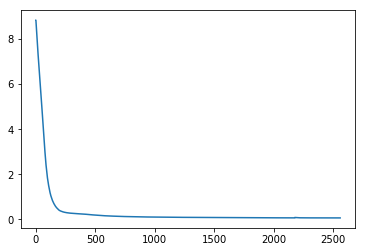

In [62]:
importlib.reload(stats)
params = {
    "x": "std-normalized",
    "name": img_name,
    "size": 150,
    "layers": 5,
    "iterations": 256,
    "blur": 5,
    "scale_decay": 0, # 0 means no scale decay
    "scale": 100000,
    "model": vgg,
    "hooks": hooks,
    "lr": 0.1,
}

meta_params = {
    "save_mode": "final" ,
    "example_feature_pyr": example_feature_pyr,
    # determine whether to save just the final image, or save at intervals while generating
}

syn = Synthesizer(meta_params)

for s in [1000000]:
    for lr in [0.01]:
        for blur in [3]:
            params["lr"] = lr
            params["scale"] = s
            params["blur"] = blur
            params["id"] = identifier(params) 

            print(params["id"])

            _, losses = syn.synthesize(params)
            plt.figure()
            plt.plot(losses)